In [1]:
import numpy as np
import pandas as pd
import cv2


import matplotlib.pyplot as plt
%matplotlib inline


import os

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.VGG16 import preprocess_input, decode_predictions
import tensorflow as tf



In [2]:
%pip install kaggle


In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d sadmansakibmahi/plant-disease-expert

100% 6.54G/6.54G [01:45<00:00, 77.3MB/s]
100% 6.54G/6.54G [01:45<00:00, 66.7MB/s]


In [5]:
%%capture

! unzip /content/plant-disease-expert.zip



In [6]:
import os

# Specify the name of the new folder
new_folder_name = 'data'

# Get the current working directory
current_path = os.getcwd()

# Create the full path for the new folder
new_folder_path = os.path.join(current_path, new_folder_name)

# Check if the folder already exists
if not os.path.exists(new_folder_path):
    # Create the new folder
    os.mkdir(new_folder_path)
    print(f"Folder '{new_folder_name}' created at {current_path}")
else:
    print(f"Folder '{new_folder_name}' already exists at {current_path}")

# Move subfolders into the new folder
source_folder = "/content/Image Data base/Image Data base/"
subfolders = ["Apple Apple scab", "Apple Black rot", "Apple Cedar apple rust", "Apple healthy"]

for subfolder in subfolders:
    source_path = os.path.join(source_folder, subfolder)
    destination_path = os.path.join(new_folder_path, subfolder)

    try:
        # Move the subfolder to the new folder
        os.rename(source_path, destination_path)
        print(f"Moved '{subfolder}' to '{new_folder_name}' folder")
    except FileNotFoundError:
        print(f"Subfolder '{subfolder}' not found in the source path")
    except FileExistsError:
        print(f"Subfolder '{subfolder}' already exists in the destination path")



Folder 'data' created at /content
Moved 'Apple Apple scab' to 'data' folder
Moved 'Apple Black rot' to 'data' folder
Moved 'Apple Cedar apple rust' to 'data' folder
Moved 'Apple healthy' to 'data' folder


In [7]:
%%capture
!pip install split-folders

import splitfolders

# Set the directory
input_folder = '/content/data'
output_folder = 'appleSplitted'

# Split the dataset into training and validation sets
splitfolders.ratio(input_folder, output=output_folder, seed=38, ratio=(.80, .20), group_prefix=None)


In [8]:
from tensorflow.keras import optimizers

NUM_CLASSES = 4
CHANNELS = 3

IMAGE_RESIZE = 224
POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

LOSS_METRICS = ['accuracy']

NUM_EPOCHS = 75
EARLY_STOP_PATIENCE = 10

BATCH_SIZE_TRAINING = 128
BATCH_SIZE_VALIDATION = 128
BATCH_SIZE_TESTING = 128

# Calculate steps per epoch for training and validation
STEPS_PER_EPOCH_TRAINING = 10417 // BATCH_SIZE_TRAINING
STEPS_PER_EPOCH_VALIDATION = 4462 // BATCH_SIZE_VALIDATION

# Calculate steps for testing
STEPS_PER_EPOCH_TEST=3721// BATCH_SIZE_TESTING
#TEST_STEPS = TEST_SAMPLES // BATCH_SIZE_TESTING


In [ ]:
# model = Sequential()
# model.add(VGG16(include_top = False, pooling = POOLING_AVERAGE, weights = 'imagenet'))

# # 2nd layer as Dense for 10-class classification using SoftMax activation
# model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# # Say not to train first layer (ResNet) model as it is already trained
# model.layers[0].trainable = False

In [9]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Define the learning rate schedule
initial_learning_rate = 0.0001
decay_steps = 1000
decay_rate = 0.9

learning_rate_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

# Assuming you have defined NUM_CLASSES and learning_rate_schedule earlier
# NUM_CLASSES = ...
# learning_rate_schedule = ...

# Load pre-trained VGG16 model with weights from ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained VGG16 model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model by adding custom layers on top of VGG16
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# Compile the model with the Adam optimizer
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (Batch  (None, 25088)             100352    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 10

In [11]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3
)

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        'appleSplitted/train',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical',
        subset='training')

validation_generator = data_generator.flow_from_directory(
        'appleSplitted/train',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical',
        subset='validation')

Found 10417 images belonging to 4 classes.
Found 4462 images belonging to 4 classes.


In [12]:
# Max number of steps that these generator will have opportunity to process their source content
# len(train_generator) should be 'no. of available train images / BATCH_SIZE_TRAINING'
# len(valid_generator) should be 'no. of available train images / BATCH_SIZE_VALIDATION'
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(128, 82, 128, 35)

In [13]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE, restore_best_weights=True)

cb_checkpointer = ModelCheckpoint(filepath = '/Users/habibaelsheikh/Desktop/uni/ai/proj/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [14]:
try:
    fit_history = model.fit(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs=NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
    )
except Exception as e:
    print("Error during training:", e)
    # Add any additional print statements or debugging information here


Epoch 1/75
81/81 [==============================] - ETA: 0s - loss: 4.9420 - accuracy: 0.8909

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 [==============================] - 103s 973ms/step - loss: 4.9420 - accuracy: 0.8909 - val_loss: 4.3283 - val_accuracy: 0.9630
Epoch 2/75
81/81 [==============================] - 70s 861ms/step - loss: 3.8461 - accuracy: 0.9913 - val_loss: 3.4852 - val_accuracy: 0.9802
Epoch 3/75
81/81 [==============================] - 69s 848ms/step - loss: 3.0832 - accuracy: 0.9963 - val_loss: 2.7832 - val_accuracy: 0.9816
Epoch 4/75
81/81 [==============================] - 68s 842ms/step - loss: 2.4318 - accuracy: 0.9982 - val_loss: 2.1842 - val_accuracy: 0.9832
Epoch 5/75
81/81 [==============================] - 69s 847ms/step - loss: 1.8912 - accuracy: 0.9990 - val_loss: 1.6951 - val_accuracy: 0.9835
Epoch 6/75
81/81 [==============================] - 69s 849ms/step - loss: 1.4493 - accuracy: 0.9996 - val_loss: 1.2992 - val_accuracy: 0.9855
Epoch 7/75
81/81 [==============================] - 69s 850ms/step - loss: 1.0973 - accuracy: 0.9998 - val_loss: 0.9878 - val_accuracy: 0.9848
Epoch 8/7

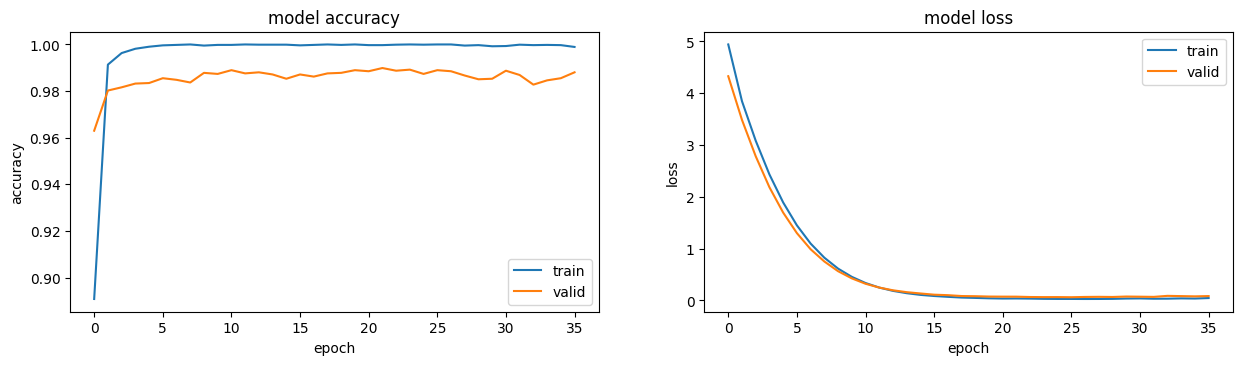

In [15]:
import matplotlib.pyplot as plt

plt.figure(1, figsize = (15,8))

plt.subplot(221)
plt.plot(fit_history.history['accuracy'])
plt.plot(fit_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.subplot(222)
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.show()

In [20]:
from sklearn.metrics import accuracy_score

actual_class_indices = test_generator.classes

accuracy = accuracy_score(actual_class_indices, predicted_class_indices)*100
print(f"Test accuracy = {accuracy}")

Test accuracy = 99.32813759742005


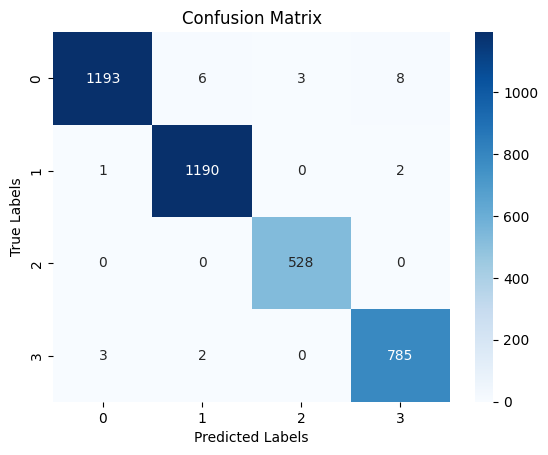

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(actual_class_indices, predicted_class_indices)

# Plot the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix ')
plt.show()


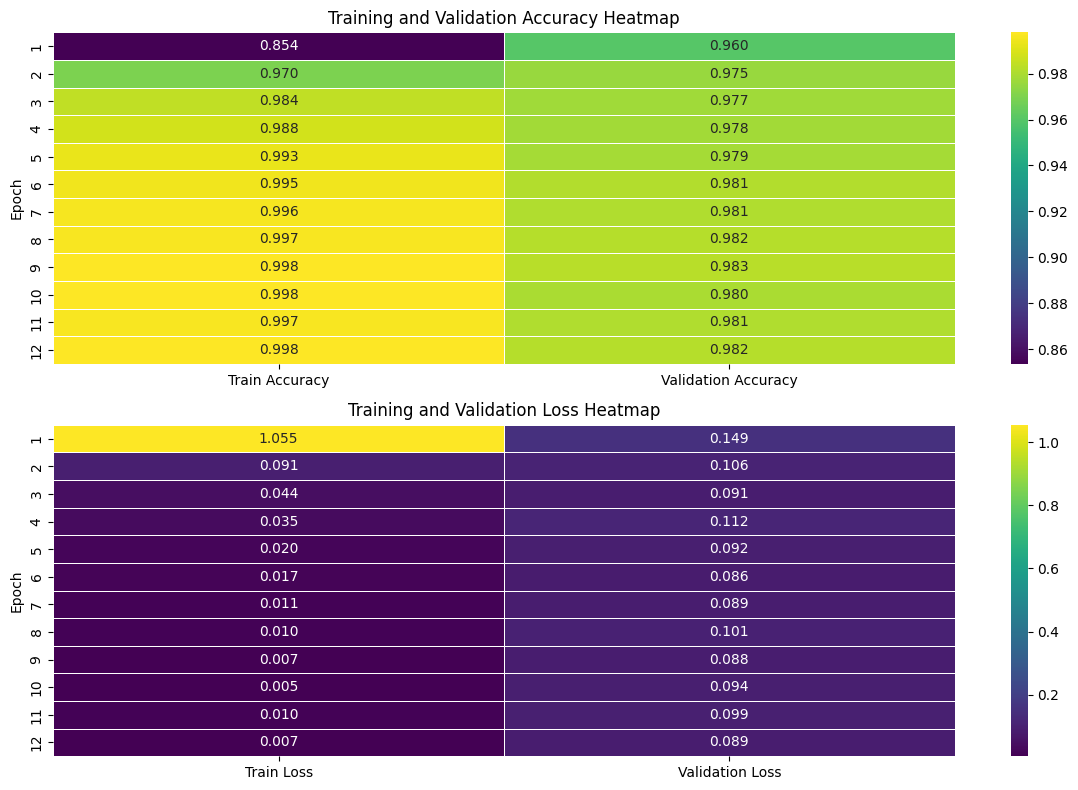

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have fit_history containing accuracy and loss values

# Extract accuracy and loss values
train_accuracy = fit_history.history['accuracy']
val_accuracy = fit_history.history['val_accuracy']
train_loss = fit_history.history['loss']
val_loss = fit_history.history['val_loss']

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'Epoch': range(1, len(train_accuracy) + 1),
    'Train Accuracy': train_accuracy,
    'Validation Accuracy': val_accuracy,
    'Train Loss': train_loss,
    'Validation Loss': val_loss
})

# Set 'Epoch' as the index for better visualization
results_df.set_index('Epoch', inplace=True)

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 8))

# Plot heatmap for accuracy
plt.subplot(2, 1, 1)
sns.heatmap(results_df[['Train Accuracy', 'Validation Accuracy']], annot=True, cmap='viridis', fmt='.3f', linewidths=.5)
plt.title('Training and Validation Accuracy Heatmap')

# Plot heatmap for loss
plt.subplot(2, 1, 2)
sns.heatmap(results_df[['Train Loss', 'Validation Loss']], annot=True, cmap='viridis', fmt='.3f', linewidths=.5)
plt.title('Training and Validation Loss Heatmap')

plt.tight_layout()
plt.show()

In [16]:
# NOTE that flow_from_directory treats each sub-folder as a class which works fine for training data
# Actually class_mode=None is a kind of workaround for test data which too must be kept in a subfolder

# batch_size can be 1 or any factor of test dataset size to ensure that test dataset is samples just once, i.e., no data is left out
test_generator = data_generator.flow_from_directory(
    directory =  'appleSplitted/val',
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

# Try batch size of 1+ in test_generator & check batch_index & filenames in resulting batches
'''
for i in test_generator:
    #print(test_generator.batch_index, test_generator.batch_size)
    idx = (test_generator.batch_index - 1) * test_generator.batch_size
    print(test_generator.filenames[idx : idx + test_generator.batch_size])
'''

Found 3721 images belonging to 4 classes.


'\nfor i in test_generator:\n    #print(test_generator.batch_index, test_generator.batch_size)\n    idx = (test_generator.batch_index - 1) * test_generator.batch_size\n    print(test_generator.filenames[idx : idx + test_generator.batch_size])\n'

In [22]:
import os

file_path = "appleSplitted/val"
exists = os.path.exists(file_path)

if exists:
    print("File exists.")
else:
    print("File does not exist.")


File exists.


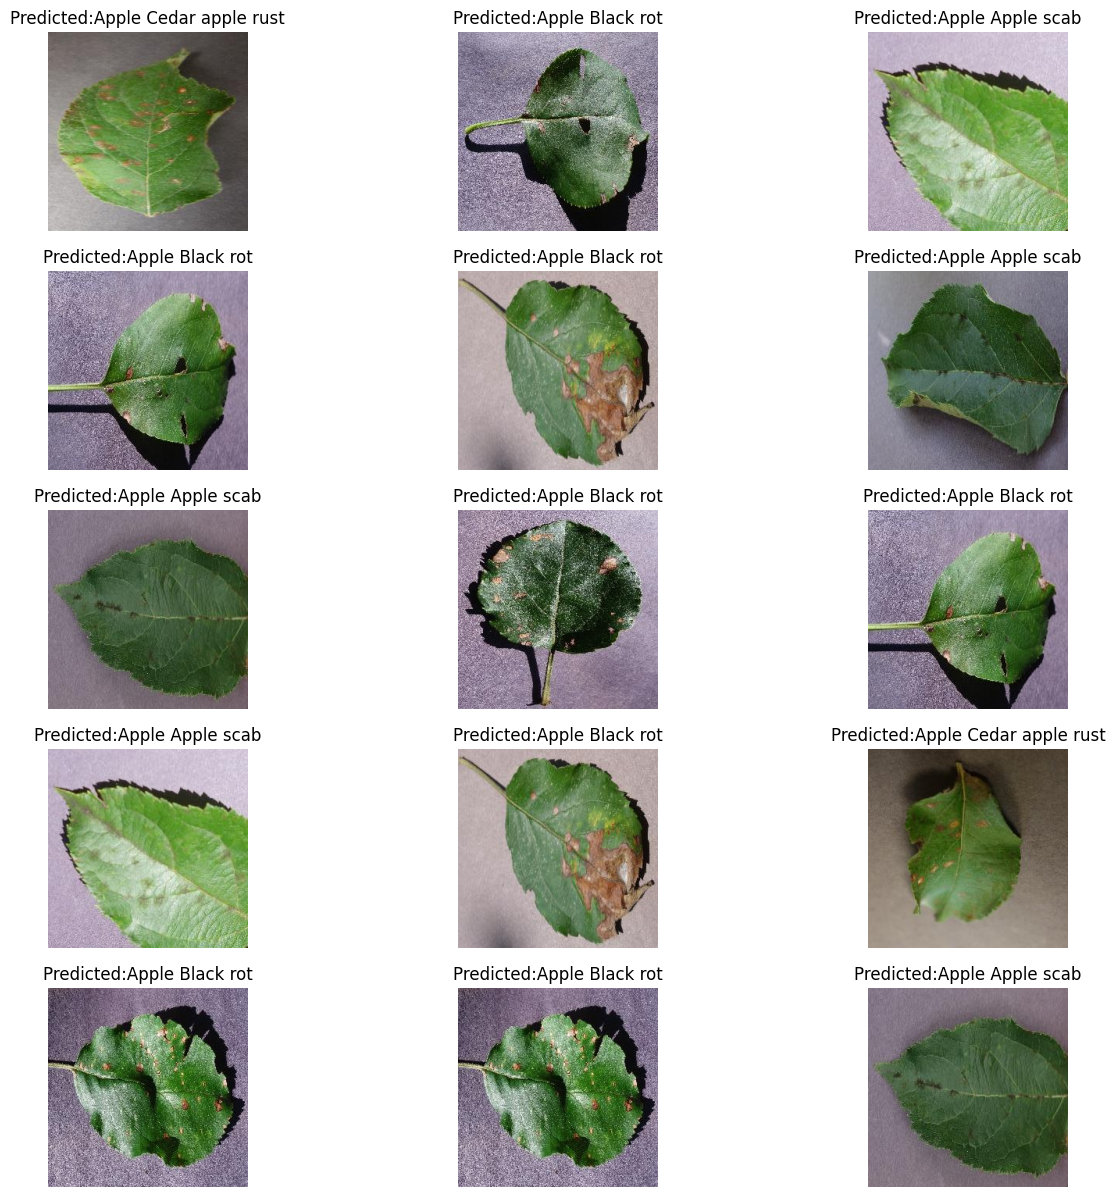

In [23]:
import random

TEST_DIR = 'appleSplitted/val/'
f, ax = plt.subplots(5, 3, figsize = (15, 15))

# Get a list of all file names in the dataset directory
class_labels = os.listdir(TEST_DIR)

for j in range(0,25):

    i = random.randrange(20, 3000, 200)
    imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)

    # a if condition else b
    predicted_class = class_labels[predicted_class_indices[i]]

    ax[j//5, j%3].imshow(imgRGB)
    ax[j//5, j%3].axis('off')

    ax[j//5, j%3].set_title("Predicted:{}".format(predicted_class))

plt.show()

In [24]:
results_df = pd.DataFrame(
    {
        'id': pd.Series(test_generator.filenames),
        'label': pd.Series(predicted_class_indices)
    })
results_df['id'] = results_df.id.str.extract('(\d+)')
results_df['id'] = pd.to_numeric(results_df['id'], errors = 'coerce')
results_df.sort_values(by='id', inplace = True)

results_df.to_csv('submission.csv', index=False)
results_df.head()

,id,label
2632,2,2
3388,3,3
2846,6,2
2170,8,1
3694,9,3


from matplotlib import pyplot as plt
_df_0['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='id', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['id']
  ys = series['label']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('label')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'id'}, axis=1)
              .sort_values('id', ascending=True))
  xs = counted['id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
import numpy as np

NUM_CLASSES = 4  # Adjust based on the number of classes in your problem
DENSE_LAYER_ACTIVATION = 'softmax'  # Choose activation based on your problem
POOLING_AVERAGE = 'max'  # Choose pooling strategy based on your problem

train_generatorc = data_generator.flow_from_directory(
        'appleSplitted/train',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical'
        )

validation_generatorc = data_generator.flow_from_directory(
        'appleSplitted/train',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical')
n_splits = 6
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Loop through the folds
for fold_index, (train_index, val_index) in enumerate(skf.split(train_generator.filenames, train_generator.classes)):
    print(f"\nTraining on Fold {fold_index + 1}/{n_splits}")

    # Create a Sequential model
    model = Sequential()

    # Add ResNet50 as the first layer (excluding top layers for custom output)
    model.add(VGG16(include_top=False, pooling=POOLING_AVERAGE, weights='imagenet'))

    # Add a Dense layer for classification
    model.add(Dense(NUM_CLASSES, activation=DENSE_LAYER_ACTIVATION))

    # Set the first layer (ResNet50) to non-trainable, as it is already pre-trained
    model.layers[0].trainable = False

    # Compile the model (adjust parameters based on your problem)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Set up Early Stopping callback to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model using generators
    fit_histc=model.fit(train_generatorc, epochs=10, validation_data=validation_generatorc, callbacks=[early_stopping])

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(validation_generator)
    print(f"Validation Accuracy for Fold {fold_index + 1}: {val_accuracy}")

Found 14879 images belonging to 4 classes.
Found 14879 images belonging to 4 classes.

Training on Fold 1/6
Epoch 1/10
117/117 [==============================] - 145s 1s/step - loss: 6.1479 - accuracy: 0.6354 - val_loss: 1.5299 - val_accuracy: 0.8456
Epoch 2/10
117/117 [==============================] - 136s 1s/step - loss: 1.0895 - accuracy: 0.8809 - val_loss: 0.8841 - val_accuracy: 0.8966
Epoch 3/10
117/117 [==============================] - 136s 1s/step - loss: 0.5995 - accuracy: 0.9256 - val_loss: 0.4523 - val_accuracy: 0.9386
Epoch 4/10
117/117 [==============================] - 136s 1s/step - loss: 0.3870 - accuracy: 0.9462 - val_loss: 0.3112 - val_accuracy: 0.9519
Epoch 5/10
117/117 [==============================] - 136s 1s/step - loss: 0.2686 - accuracy: 0.9569 - val_loss: 0.2155 - val_accuracy: 0.9640
Epoch 6/10
117/117 [==============================] - 135s 1s/step - loss: 0.2061 - accuracy: 0.9654 - val_loss: 0.1429 - val_accuracy: 0.9741
Epoch 7/10
117/117 [==============

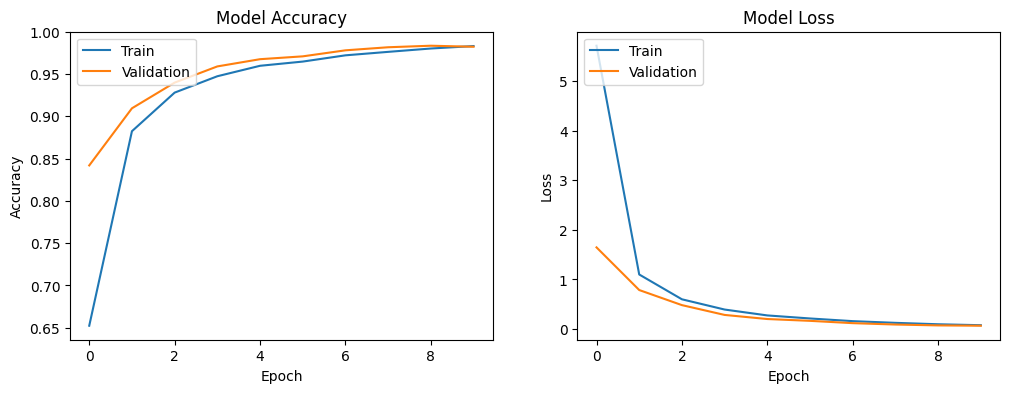

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot training and validation curves
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(fit_histc.history['accuracy'])
plt.plot(fit_histc.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(fit_histc.history['loss'])
plt.plot(fit_histc.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have already trained your model and have predictions and true labels
predictions = model.predict(test_generator)

# For binary classification
y_true = test_generator.labels  # No need for np.argmax

# For multiclass classification (if NUM_CLASSES > 2)
# y_true = np.argmax(test_generator.labels, axis=1)

y_pred = np.argmax(predictions, axis=1)



# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Optionally, print classification report
print("Classification Report:\n", classification_report(y_true, y_pred))


/Users/habibaelsheikh/anaconda3/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


NameError: name 'model' is not defined